In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPooling1D, LeakyReLU
from keras.layers import Activation
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [81]:
import time

class SuggestPrediction:
    
    def __init__(self, file_name):
        
        with open(file_name) as f:
            info = []

            for i in f.readlines():

                qr = i.split(',')
                if len(qr) == 6:

                    qr[5] = qr[5].strip()
                    info.append(qr)

        data = pd.DataFrame(info[1:], columns=info[0]).drop(['action_object', 'id'], axis=1)
        
        cats = {}
        for key, val in enumerate(data['itemtype'].unique()):
            cats[val] = key + 1

        data['cats_class'] = data['itemtype'].map(cats)

        self.total_cats = len(data['itemtype'].unique()) + 1
        
        print('Number of categories:', self.total_cats)

        self.data = data[:100000]
    
    def tokenize(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.data['query'].tolist())

        textSeq = tokenizer.texts_to_sequences(self.data['query'].tolist())
        
        total_words = len(tokenizer.word_index)
        print('There are {} words in dictionary'.format(total_words))

        return textSeq
    
    def load_data_from_arrays(self, strings, labels, train_test_split=0.9):
        data_size = len(strings)
        test_size = int(data_size - round(data_size * train_test_split))
        print("Test size: {}".format(test_size))

        print("\nTraining set:")
        x_train = strings[test_size:]
        print("\t - x_train: {}".format(len(x_train)))
        y_train = labels[test_size:]
        print("\t - y_train: {}".format(len(y_train)))

        print("\nTesting set:")
        x_test = strings[:test_size]
        print("\t - x_test: {}".format(len(x_test)))
        y_test = labels[:test_size]
        print("\t - y_test: {}".format(len(y_test)))

        return x_train, x_test, y_train, y_test
    
    def data_preprocessing(self, x_train, x_test,
                                  y_train, y_test, num_words):
        
        self.num_words = num_words
        num_classes = self.total_cats

        print(u'\n Convert user queries to vector of numbers...')
        tokenizer = Tokenizer(num_words=num_words)
        x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
        x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
        print('\t - X_train:', x_train.shape)
        print('\t - X_test:', x_test.shape)


        print(u'\n Convert categories to matrix of binary numbers '
              u'for using categorical_crossentropy...')
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
        print('\t - y_train shape:', y_train.shape)
        print('\t - y_test shape:', y_test.shape)
        
        return x_train, x_test, y_train, y_test
        
    def build(self, epochs):
        
        textSeq = self.tokenize()
        x_train, x_test, y_train, y_test = self.load_data_from_arrays(textSeq, self.data['cats_class'], train_test_split=0.8)
        x_train, x_test, y_train, y_test = self.data_preprocessing(x_train, x_test, y_train, y_test, 20000)

        model = Sequential()
        model.add(Dense(512, input_shape=(num_words,)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.total_cats))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

        print(model.summary())
        
        print('\n Start training...\n')
        time.sleep(2)
        
        history = model.fit(x_train, y_train,
                   batch_size=32,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)
        
        return history
        
        

suggest = SuggestPrediction('caregory_data.csv').build(10)

Number of categories: 49
There are 36652 words in dictionary
Test size: 20000

Training set:
	 - x_train: 80000
	 - y_train: 80000

Testing set:
	 - x_test: 20000
	 - y_test: 20000

 Convert user queries to vector of numbers...
	 - X_train: (80000, 20000)
	 - X_test: (20000, 20000)

 Convert categories to matrix of binary numbers for using categorical_crossentropy...
	 - y_train shape: (80000, 49)
	 - y_test shape: (20000, 49)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               10240512  
_________________________________________________________________
activation_23 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 49)  

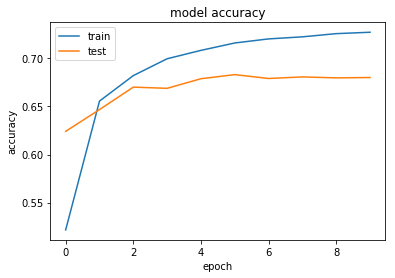

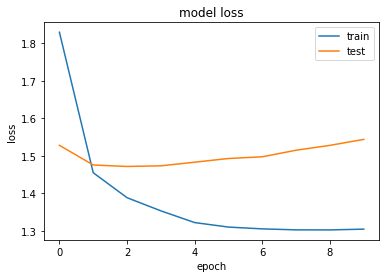

In [82]:
# График точности модели
plt.plot(suggest.history['acc'])
plt.plot(suggest.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# График оценки loss
plt.plot(suggest.history['loss'])
plt.plot(suggest.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()